<center><h1>Generar Modelo para Competencia Kaggle de Deep Learning</h1></center>

# Cargar librerias

In [1]:
# Cargar librerias
import numpy as np
import random
import os

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from itertools import product

pd.options.display.max_columns = 90

# Cargar Datos

In [2]:
# Cargar Datos de entrenamiento
df_train = pd.read_csv('train_data.csv')

# vista previa
display(df_train.head(5))

,ID,Bankruptcy,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
0,1,0,0.087661,1.900349e-04,0.131094,0.583345,0.000000,0.815892,0.395719,0.089276,0.000489,0.281141,0.665066,0.066387,0.249061,0.140873,0.431139,0.191173,0.297644,0.024285,0.725172,0.049712,0.078449,0.740116,4.721018e-04,0.860095,0.002406,0.791956,0.217159,0.828121,0.898076,0.059736,0.124798,0.026398,0.437043,0.999062,0.012959,0.861571,0.711694,0.379531,0.620656,0.060332,0.359905,0.009406,4.288144e-03,2.237306e+09,0.586047,5.901952e-05,0.258266,0.942833,0.038263,0.833613,7.620685e+10,0.349014,1,0.223720,0.801737,0,0.839112,0.036551,0.591350,0.007401,0.913175,0.489822,0.138714
1,2,0,0.021892,5.371576e-04,0.086167,0.695478,0.209649,0.768636,0.163505,0.000000,0.018823,0.304522,0.602284,0.038972,0.262613,0.137160,0.322354,0.391213,0.792984,0.067274,0.567918,0.139836,0.343944,0.623515,3.115766e+07,0.819082,0.058836,0.769482,0.211842,0.698552,0.860089,0.139002,0.173522,0.020867,0.502984,0.999227,0.006648,0.819186,0.808840,0.609301,0.694097,0.020014,0.427782,0.142211,1.927473e-04,2.537529e-03,0.561915,1.385376e-03,0.141277,0.962914,0.000594,0.173683,1.003696e+06,0.377744,1,0.324763,0.791203,0,0.908450,0.126752,0.766066,0.020514,0.849241,0.550247,0.704211
2,3,0,0.102249,2.178329e-04,0.157755,0.766934,0.272061,0.643316,0.181571,0.010180,0.020323,0.398060,0.571545,0.102786,0.264661,0.166239,0.416704,0.170455,0.494234,0.015204,0.607235,0.038620,0.100376,0.754268,2.301743e-04,0.870927,0.103190,0.721866,0.217448,0.709177,0.820039,0.165287,0.267027,0.031782,0.556357,0.999100,0.002282,0.857014,0.662214,0.501465,0.566415,0.035103,0.322577,0.016698,5.061000e-03,5.296747e-04,0.609651,9.989531e-03,0.144202,0.957835,0.002228,0.170233,2.675561e+05,0.463732,1,0.360892,0.803126,0,0.865943,0.018152,0.687211,0.004363,0.865814,0.447168,0.398086
3,4,0,0.029972,4.915756e+10,0.249279,0.611580,0.288357,0.752782,0.409196,0.018603,0.051621,0.569484,0.597299,0.020687,0.323814,0.106693,0.316508,0.283815,0.568482,0.055694,0.554564,0.041208,0.301615,0.647968,2.560633e-04,0.895735,0.009577,0.709324,0.099247,0.834494,0.861415,0.234282,0.458725,0.021961,0.321767,0.999235,0.013867,0.816414,0.736790,0.546017,0.630496,0.003352,0.353371,0.106083,1.361321e+09,3.982768e-04,0.689417,4.283614e+09,0.151899,0.939676,0.048031

## Separar variable objetivo  y predictoras

In [3]:
# Se parar variable predictoras
x = df_train.drop(columns='Bankruptcy')

# Se parar variable objetivo 
y = df_train['Bankruptcy']

# Análisis preliminar de variables

In [4]:
# Tamaño del data set x
print("Tamaño del data set: \n", x.shape, "\n")

# Tipos de datos en el data set x
print("Tipos de datos: \n", x.dtypes.value_counts())

Tamaño del data set: 
 (2050, 64) 

Tipos de datos: 
 float64    61
int64       3
Name: count, dtype: int64


In [5]:
# Tamaño del data set y
print("Tamaño del data set: \n", y.shape, "\n")

# Tipo de dato y, distribucion de clases
print("Tipo de dato y distribucion de clases: \n", y.value_counts())

Tamaño del data set: 
 (2050,) 

Tipo de dato y distribucion de clases: 
 Bankruptcy
0    1988
1      62
Name: count, dtype: int64


In [6]:
# Contar Na x
display(x.isna().sum().sum())

# Contar Na y
display(y.isna().sum())

0

0

In [7]:
# Datos estadisticos descriptivos de x
x.describe().round(2)

,ID,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
count,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.0,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00
mean,1276.68,0.05,1.143592e+10,0.17,0.66,0.15,0.79,0.29,9.294008e+07,1.131508e+06,0.40,0.64,0.06,0.30,0.17,0.35,0.26,0.57,0.08,0.62,0.09,0.17,0.68,5.888515e+07,0.86,4.005590e+08,0.72,0.18,0.77,0.84,0.15,0.26,4319.06,0.45,1.00,0.02,0.83,0.73,0.47,0.66,3.175659e+07,0.40,0.06,5.272116e+09,4.907951e+09,0.61,9.853138e+09,0.17,0.94,1.063234e+06,0.31,2.488923e+10,0.47,1.0,0.25,0.81,0.00,0.84,0.06,0.66,0.02,0.87,0.53,0.46
std,733.77,0.04,6.637064e+10,0.07,0.07,0.17,0.19,0.09,1.985623e+09,3.534875e+07,0.09,0.08,0.05,0.09,0.16,0.09,0.09,0.22,0.06,0.07,0.08,0.08,0.06,1.366092e+09,0.04,1.807937e+10,0.06,0.08,0.05,0.03,0.09,0.09,195550.62,0.09,0.00,0.04,0.04,0.05,0.09,0.07,7.739081e+08,0.09,0.06,4.620072e+10,4.095018e+10,0.09,5.964096e+10,0.09,0.02,3.442681e+07,0.22,8.869889e+10,0.08,0.0,0.09,0.04,0.02,0.06,0.05,0.06,0.02,0.03,0.08,0.21
min,1.00,0.01,0.000000e+00,0.03,0.49,0.00,0.02,0.13,0.000000e+00,0.000000e+00,0.24,0.21,0.00,0.08,0.00,0.21,0.09,0.00,0.00,0.00,0.01,0.02,0.56,0.000000e+00,0.00,0.000000e+00,0.62,0.04,0.51,0.75,0.00,0.10,0.00,0.30,0.98,0.00,0.75,0.51,0.29,0.42,0.000000e+00,0.26,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.00,0.66,0.000000e+00,0.00,0.000000e+00,0.33,1.0,0.01,0.73,0.00,0.63,0.00,0.45,0.00,0.81,0.08,0.00
25%,645.25,0.02,0.000000e+00,0.11,0.61,0.00,0.68,0.22,0.000000e+00,0.000000e+00,0.33,0.59,0.02,0.23,0.06,0.28,0.19,0.41,0.03,0.57,0.04,0.11,0.63,0.000000e+00,0.84,1.000000e-02,0.67,0.12,0.74,0.81,0.08,0.19,0.02,0.38,1.00,0.01,0.80,0.69,0.40,0.61,0.000000e+00,0.34,0.02,0.000000e+00,0.000000e+00,0.55,0.000000e+00,0.10,0.94,1.000000e-02,0.13,7.606215e+05,0.41,1.0,0.18,0.78,0.00,0.80,0.03,0.61,0.01,0.85,0.46

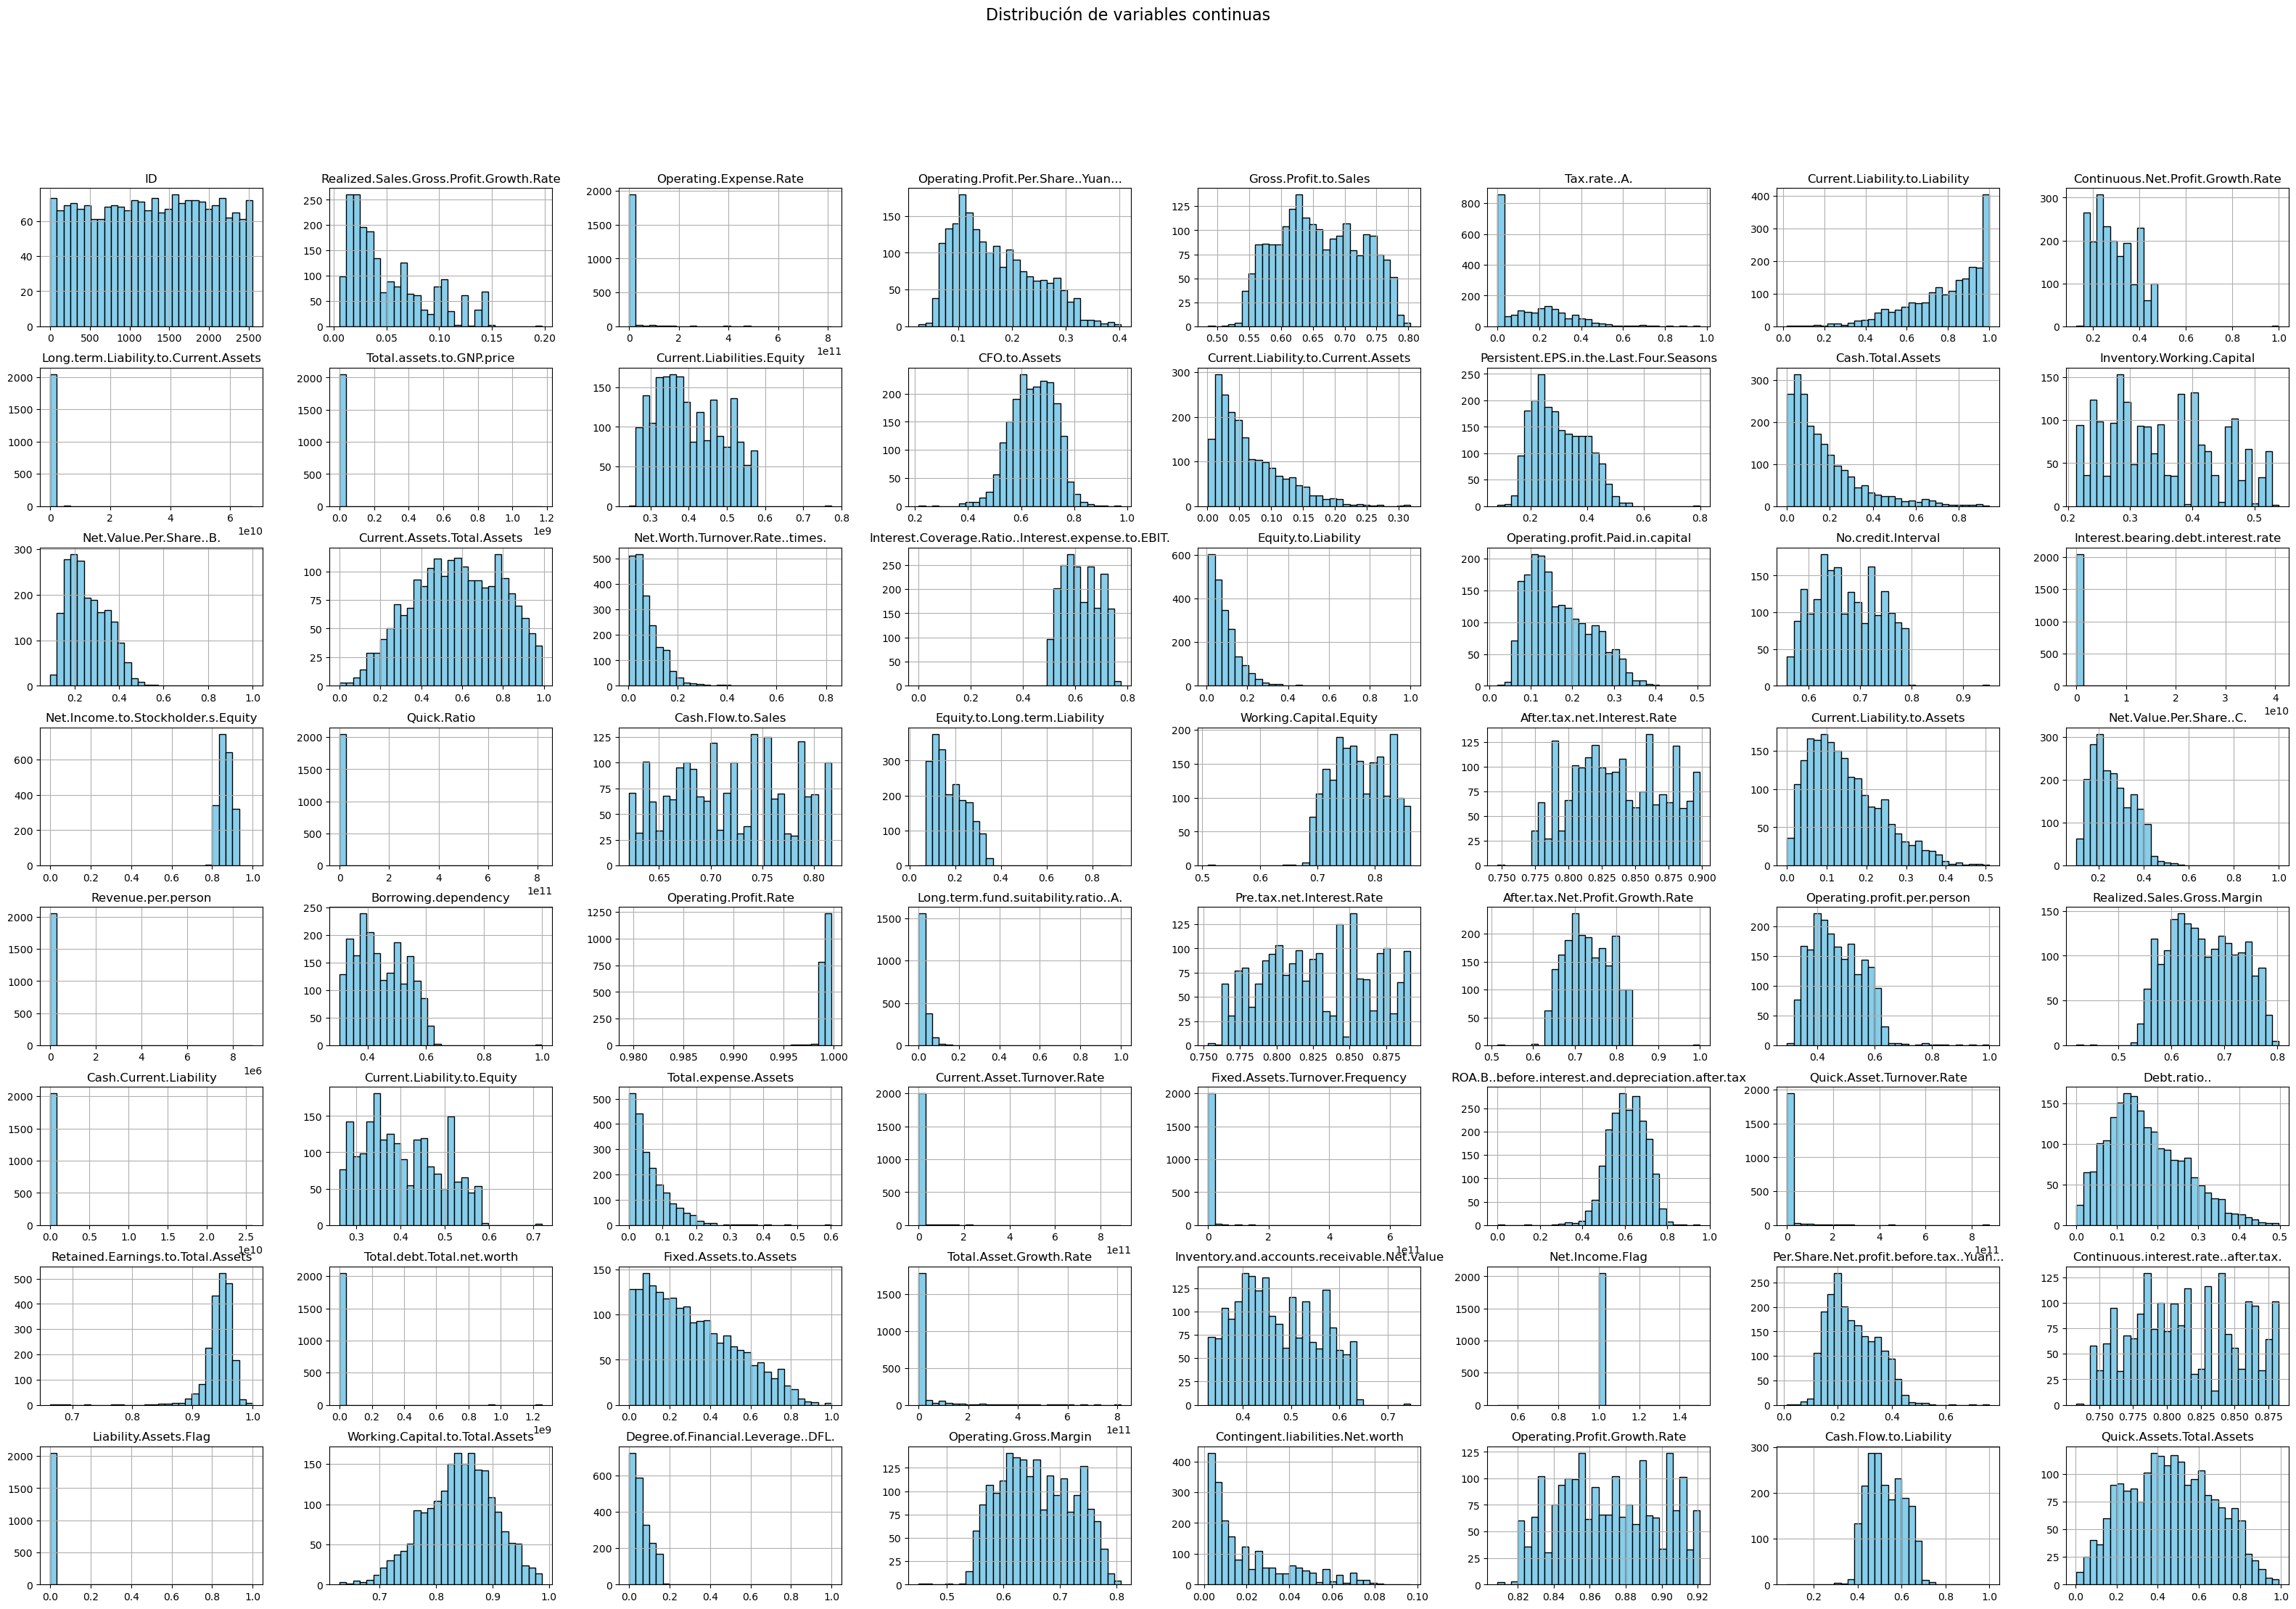

In [8]:
# Histogramas de las variables continuas
x.hist(bins=30, figsize=(40, 25), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables continuas", fontsize=16)
plt.show()

C:\Users\danie\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


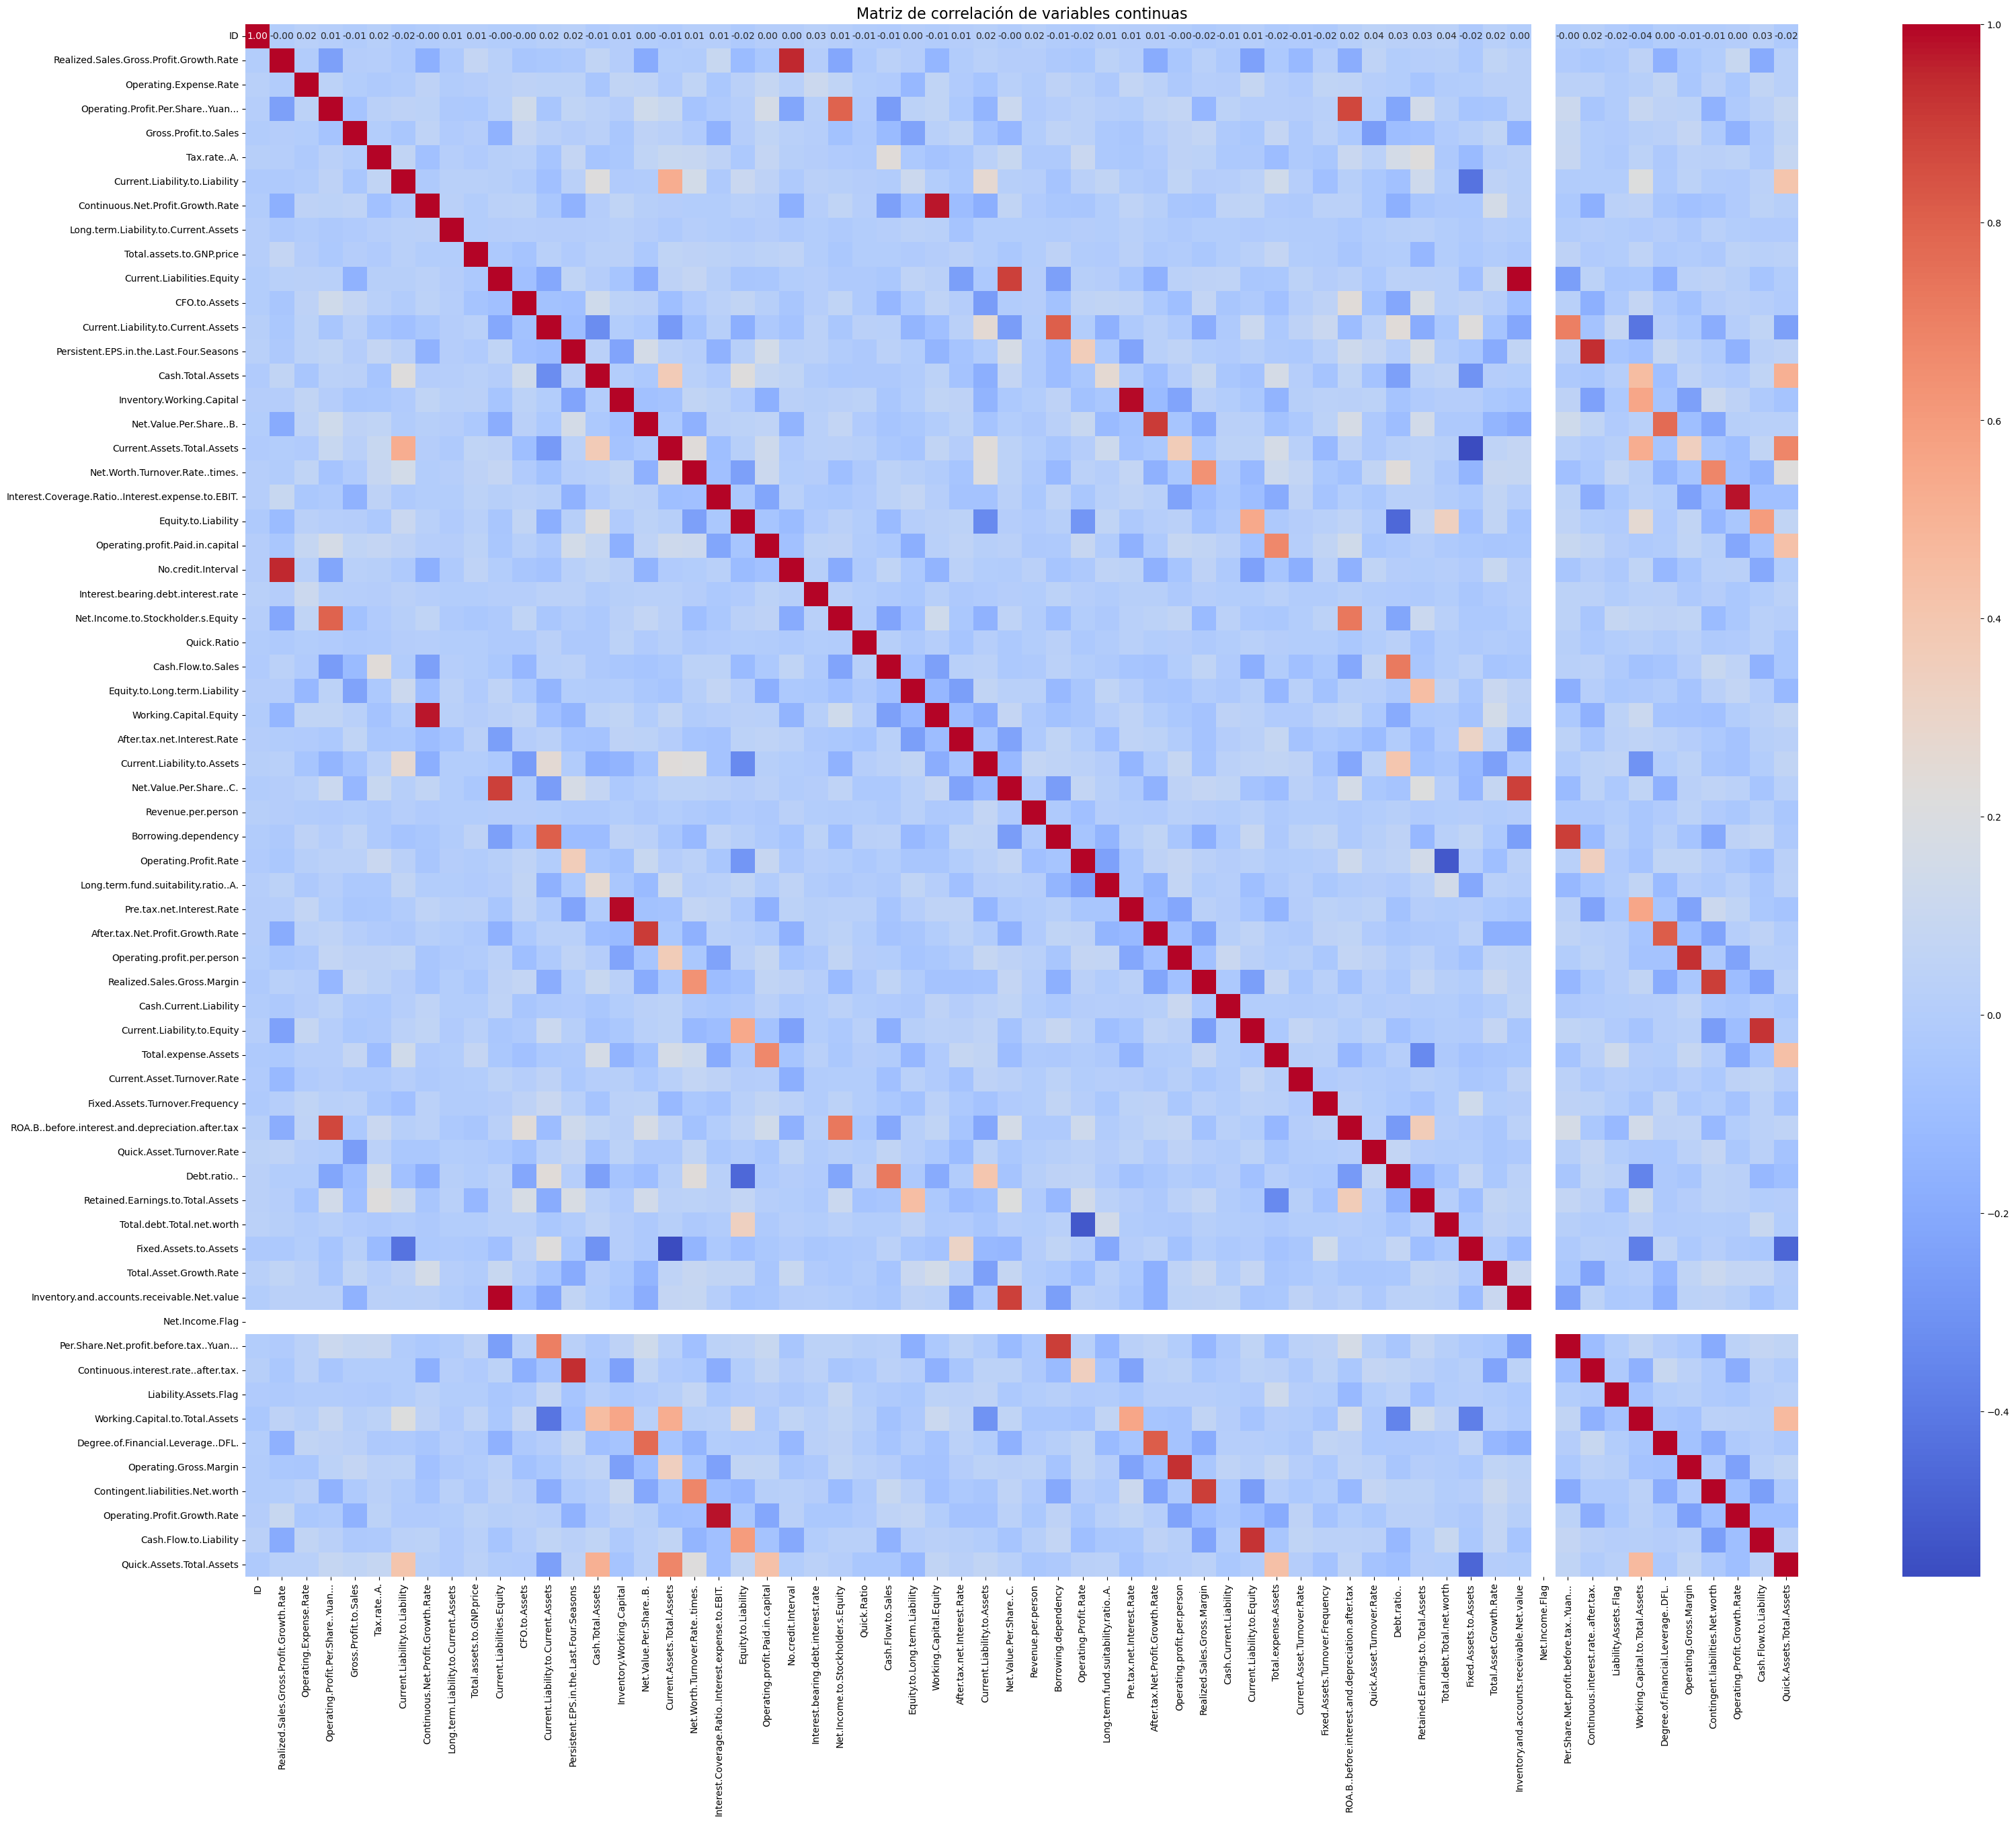

In [9]:
# Correlograma (matriz de correlación)
plt.figure(figsize=(40, 30))
correlation_matrix = x.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación de variables continuas", fontsize=16)
plt.show()

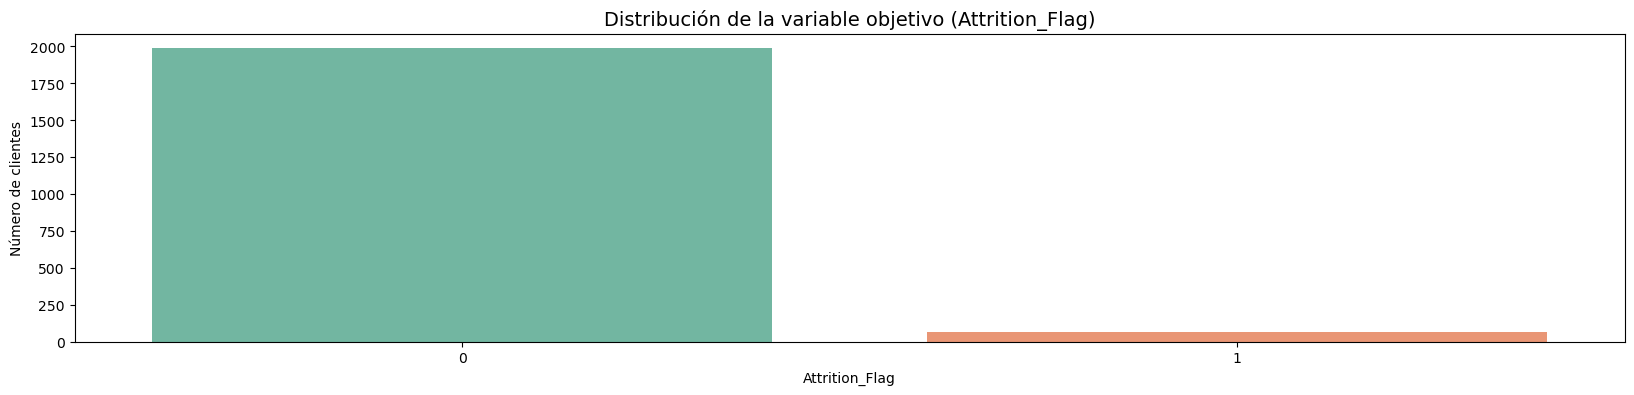

In [10]:
# Distribución de la variable objetivo
plt.figure(figsize=(20, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Distribución de la variable objetivo (Attrition_Flag)", fontsize=14)
plt.xlabel("Attrition_Flag")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
plt.show()

# Estimación del modelo usando una red neuronal con keras

## Modelo 1

### Seleccion de variables

In [11]:
var_eliminar = ["ID"]

In [12]:
x_filtro = x.drop(columns=var_eliminar)
print(f"Columnas de entrada {x_filtro.shape[1]}")

Columnas de entrada 63


### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_filtro, y, stratify=y, test_size=0.1, random_state=42)

In [14]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformar a formato NumPy
X_train_array = np.array(X_train_scaled, dtype=np.float32)
X_test_array = np.array(X_test_scaled, dtype=np.float32)

y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

In [15]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [16]:
def preprocesamiento1(df, lista_eliminar):

    df_filtro = df.drop(columns=lista_eliminar)
    
    scaler = StandardScaler()
    
    df_scaled = scaler.fit_transform(df_filtro)
    df_array = np.array(df_scaled, dtype=np.float32)

    return df_array


### Entrenamiento modelo

In [23]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.0000001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [26]:
history = model.fit(
    X_train_array, y_train_array,
    epochs=150,
    validation_split=0.15,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    batch_size=64,
    verbose=1
)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4664 - loss: 1.0251 - val_accuracy: 0.7509 - val_loss: 0.5765
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5141 - loss: 0.7371 - val_accuracy: 0.6643 - val_loss: 0.6282
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5587 - loss: 0.6739 - val_accuracy: 0.6679 - val_loss: 0.6293
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5696 - loss: 0.5613 - val_accuracy: 0.6859 - val_loss: 0.6070
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5919 - loss: 0.5045 - val_accuracy: 0.7329 - val_loss: 0.5778
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6127 - loss: 0.4679 - val_accuracy: 0.7762 - val_loss: 0.5360
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6648 - loss: 0.5566 - val_accuracy: 0.8051 - val_loss: 0.5034
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6981 - loss: 0.4691 - val_accuracy: 0.80

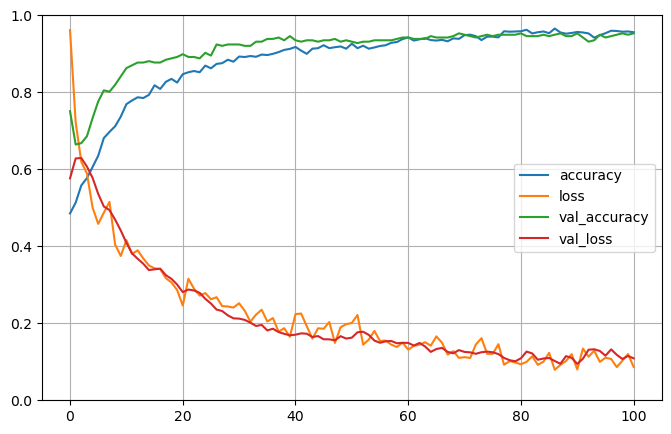

In [27]:
# graficar el entrenamiento del modelo
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [28]:
test_loss, test_acc = model.evaluate(X_test_array, y_test_array)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9581 - loss: 0.1318 


## Modelo 2

### Seleccion de variables

In [ ]:
var_eliminar2 = ["ID"]

In [ ]:
x_filtro2 = x.drop(columns=var_eliminar2)
print(f"Columnas de entrada {x_filtro2.shape[1]}")

### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_filtro2, y, stratify=y, test_size=0.1, random_state=42)

In [ ]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Manejar desbalanceo con SMOTE
sm = SMOTE(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# Transformar a formato NumPy
X_train_array = np.array(X_resampled, dtype=np.float32)
X_test_array = np.array(X_test_scaled, dtype=np.float32)

y_train_array = np.array(y_resampled, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

### Entrenamiento del modelo

In [ ]:
model2 = keras.models.Sequential()

model2.add(keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.4))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(32, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
opt2=Adam(learning_rate=0.0003)
opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.0000001)
model2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6
)

In [ ]:
history2 = model2.fit(
    X_train_array, y_train_array,
    epochs=100,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr],
    batch_size=64,
    verbose=2
)

In [ ]:
# graficar el entrenamiento del modelo
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
test_loss2, test_acc2 = model2.evaluate(X_test_array, y_test_array)

# Prediccion nuevos datos

In [ ]:
# Cargar Datos de prueba
df_test = pd.read_csv('test_data.csv')

# vista previa
df_test.head()

In [ ]:
def preprocesamiento1(df, lista_eliminar):

    df_filtro = df.drop(columns=lista_eliminar)
    
    scaler = StandardScaler()
    
    df_scaled = scaler.fit_transform(df_filtro)
    df_array = np.array(df_scaled, dtype=np.float32)

    return df_array


In [ ]:
df_test.shape

In [ ]:
df_predict = preprocesamiento1(df_test, var_eliminar)

In [ ]:
df_predict.shape

In [ ]:
y_predict = model.predict(df_predict)

In [ ]:
y_predict

In [ ]:
y_predict = [round(x[0], 3) for x in y_predict]

In [ ]:
resultado = pd.DataFrame({'ID': df_test['ID'].values, 'Probability': y_predict})
resultado.head()

In [ ]:
resultado.groupby("Probability").size()

In [ ]:
# Crear csv con las predicciones
resultado.rename(columns={'id':'ID'}, inplace=True)
resultado.rename(columns={'Probability':'Bankruptcy'}, inplace=True)

resultado.to_csv('submission.csv', index=False)